<a href="https://colab.research.google.com/github/ivykhanhvy/BACE-MoleculeNet/blob/main/BACE_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepchem
!pip install chemprop
!pip install optuna

In [ ]:
import deepchem as dc
import chemprop
import pandas as pd
import numpy as np
import torch
import sklearn
import rdkit
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem.Draw import IPythonConsole
from collections import Counter

In [ ]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer = 'ECFP', split = None)

In [ ]:
df = datasets[0].to_dataframe()
print("BACE Regression Dataset")
print(f'Number of compounds: {len(df)}')
print(f'Max pIC50:{max(df["y"])}')
print(f'Min pIC50: {min(df["y"])}')
print(f'Amount of pIC > 0: {Counter(df["y"] > 0)}')
df.head()

BACE Regression Dataset
Number of compounds: 1513
Max pIC50:2.9813471805938603
Min pIC50: -2.9638778955932974
Amount of pIC > 0: Counter({True: 838, False: 675})


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1018,X1019,X1020,X1021,X1022,X1023,X1024,y,w,ids
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.961970,1.0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.737651,1.0,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.622222,1.0,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.622222,1.0,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.622222,1.0,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...


In [ ]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset=datasets[0],
    frac_train=0.8,
    frac_valid=0.1,
    frac_test=0.1)

In [ ]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))
print(train_dataset.X.shape)
print(train_dataset.y.shape)
print(train_dataset.w.shape)
print(train_dataset.ids)

1210
151
152
(1210, 1024)
(1210, 1)
(1210, 1)
['S1(=O)(=O)N(CCCC1)c1cc(cc(NCC)c1)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]Cc1cc(cnc1)C#N'
 'O1c2ncc(cc2C([NH2+]CC(O)C(NC(=O)COC)Cc2cc(ccc2)C#C)CC12CCC2)CC(C)(C)C'
 'S1(=O)CC(Cc2cc(OC(COC)C(F)(F)F)c(N)c(F)c2)C(O)C([NH2+]Cc2cc(ccc2)C(CO)(C)C)C1'
 ...
 'S1(=O)(=O)CC(Cc2cc(O[C@H](COCCOC)C(F)(F)F)c(N)c(F)c2)C(O)C([NH2+]Cc2cc(ccc2)C(C)(C)C)C1'
 's1cc(cc1C(=O)CC)C1(N=C(N)N(C)C1=O)c1cc(ccc1)-c1cccnc1F'
 'O=C(NCCC(C)(C)C)C(Cc1cc2cc(ccc2nc1N)-c1ncccc1C#N)C']


In [ ]:
model = dc.models.MultitaskRegressor(n_tasks = 1, n_features = 1024, layer_size = [1000], dropout = 0.2)
print("Loss function before tuning:")
model.fit(train_dataset, nb_epoch = 100)

Loss function before tuning:


0.03930161237716675

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from deepchem.metrics import Metric
predicted_valid = model.predict(valid_dataset)
predicted_valid = predicted_valid.flatten()

metrics = [dc.metrics.Metric(dc.metrics.mean_squared_error),
           dc.metrics.Metric(dc.metrics.r2_score)]
eval_valid = model.evaluate(valid_dataset, metrics, transformers)
print("Regression report")
print(f'MSE: {mean_squared_error(valid_dataset.y, predicted_valid)}')
print(f'R2: {r2_score(valid_dataset.y, predicted_valid)}')
print(eval_valid)

Regression report
MSE: 0.4329831442011944
R2: 0.5912439643926071
{'mean_squared_error': np.float64(0.7797559457700455), 'r2_score': np.float64(0.5912439643926071)}


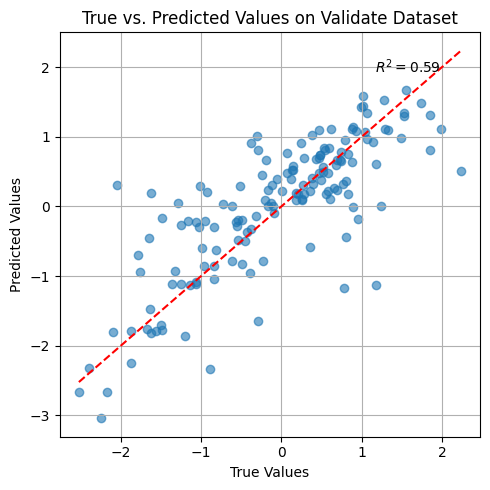

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(valid_dataset.y, predicted_valid, alpha=0.6)
plt.plot([valid_dataset.y.min(), valid_dataset.y.max()], [valid_dataset.y.min(), valid_dataset.y.max()], 'r--') # y=x
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values on Validate Dataset")
plt.text(0.75, 0.9, f'$R^2 = {r2_score(valid_dataset.y, predicted_valid):.2f}$', transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import optuna
def objective(trial):
  metrics = dc.metrics.Metric(dc.metrics.r2_score, mode = 'regression')
  num_layers = trial.suggest_int('num_layers',1,3)
  layer_sizes = [trial.suggest_int(f'layer_{i}_size', 128, 1024, step = 128) for i in range(num_layers)]
  dropouts = [trial.suggest_float(f'dropout_{i}',0.2,0.5, step = 0.1) for i in range(num_layers)]
  learning_rate = trial.suggest_float('learning_rate',1e-5,1e-3, step = 1e-5)
  nb_epoch = trial.suggest_int('nb_epoch',10,100,step = 10)

  model = dc.models.MultitaskRegressor(n_tasks = 1, n_features = 1024, layer_size = layer_sizes, dropout = dropouts, learning_rate =learning_rate)
  model.fit(train_dataset, nb_epoch = nb_epoch)
  scores = model.evaluate(valid_dataset, metrics, transformers)
  return scores[metrics.name]

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2025-06-04 01:01:04,972] A new study created in memory with name: no-name-d5e700ef-4930-4fe1-88aa-d2317f1dfc57
[I 2025-06-04 01:01:10,000] Trial 0 finished with value: 0.6827699279546459 and parameters: {'num_layers': 3, 'layer_0_size': 1024, 'layer_1_size': 896, 'layer_2_size': 896, 'dropout_0': 0.4, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.00022, 'nb_epoch': 20}. Best is trial 0 with value: 0.6827699279546459.
[I 2025-06-04 01:01:18,383] Trial 1 finished with value: 0.697062025430988 and parameters: {'num_layers': 2, 'layer_0_size': 128, 'layer_1_size': 384, 'dropout_0': 0.30000000000000004, 'dropout_1': 0.5, 'learning_rate': 0.00035000000000000005, 'nb_epoch': 40}. Best is trial 1 with value: 0.697062025430988.
[I 2025-06-04 01:01:30,186] Trial 2 finished with value: 0.6593734149606493 and parameters: {'num_layers': 2, 'layer_0_size': 896, 'layer_1_size': 384, 'dropout_0': 0.2, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.0007

Best trial:
  Value: 0.7074647621696009
  Params: 
    num_layers: 2
    layer_0_size: 128
    layer_1_size: 512
    dropout_0: 0.30000000000000004
    dropout_1: 0.2
    learning_rate: 0.00022
    nb_epoch: 40


In [ ]:
valid_model = dc.models.MultitaskRegressor(n_tasks = 1, n_features = 1024, layer_size = [128,512], dropout = [0.3,0.2],learning_rate = 0.0002)
print("Loss function after tuning:")
valid_model.fit(train_dataset, nb_epoch = 40)

Loss function after tuning:


0.23207418918609618

In [ ]:
predicted_valid_2 = valid_model.predict(valid_dataset)
predicted_valid_2 = predicted_valid_2.flatten()
print("Regression report")
print(f'MSE: {mean_squared_error(valid_dataset.y, predicted_valid_2)}')
print(f'R2: {r2_score(valid_dataset.y, predicted_valid_2)}')

Regression report
MSE: 0.36737316517806873
R2: 0.6531828072342936


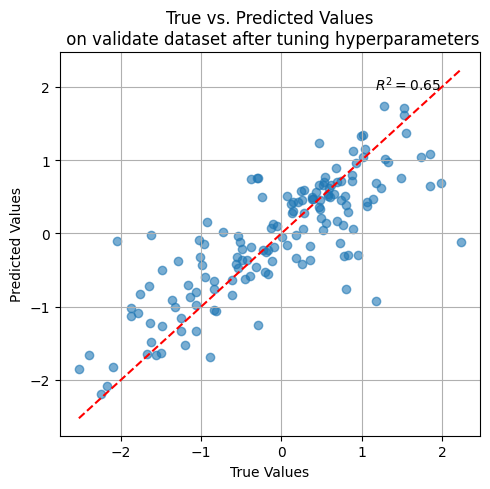

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(valid_dataset.y, predicted_valid_2, alpha=0.6)
plt.plot([valid_dataset.y.min(), valid_dataset.y.max()], [valid_dataset.y.min(), valid_dataset.y.max()], 'r--') # y=x
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values\n on validate dataset after tuning hyperparameters")
plt.text(0.75, 0.9, f'$R^2 = {r2_score(valid_dataset.y, predicted_valid_2):.2f}$', transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
predicted_test = valid_model.predict(test_dataset)
predicted_test = predicted_test.flatten()
print("Regression report")
print(f'MSE: {mean_squared_error(test_dataset.y, predicted_test)}')
print(f'R2: {r2_score(test_dataset.y, predicted_test)}')

Regression report
MSE: 0.3033457407417297
R2: 0.6915633875401446


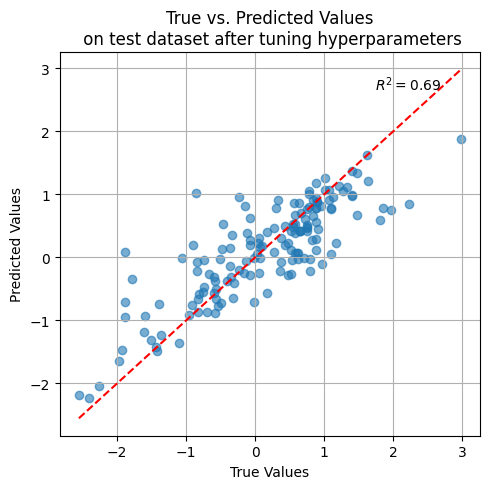

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(test_dataset.y, predicted_test, alpha=0.6)
plt.plot([test_dataset.y.min(), test_dataset.y.max()], [test_dataset.y.min(), test_dataset.y.max()], 'r--') # y=x
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values\n on test dataset after tuning hyperparameters")
plt.text(0.75, 0.9, f'$R^2 = {r2_score(test_dataset.y, predicted_test):.2f}$', transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()